# Model selection

En este notebook vamos a realizar las siguientes tareas:

1. Combinar todas las funciones de preprocesamiento de datos vistas hasta ahora en los notebooks *Data_Exploration* y *Feature_Engineering* para generar un pipeline automatizado.
2. Realizar un análisis de distintos algortimos de Machine Learning para ver cual es el más óptimo para el problema
3. Optimización de hiperparámetros, a través de una búsqueda Grid Search sobre los distintos modelos analizados

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

%matplotlib inline

In [2]:
data = pd.read_csv('../../datasets/Jobs/ds_job.csv')
data1 = data.copy()

## 1. Data Pipeline

### 1.1 Feature Engineering

Las distintas funciones vistas hasta ahora en el notebook de Feature Engineering (algunas han sido recodificadas para que el proceso sea más automático. Además, solo se han incluido las funciones de creación de las variables más importantes para el futuro modelo) son:

In [3]:
#############################################################
###       Funciones para la creación de variables         ###
#############################################################

## Función para discretizar la variable experiencia en buckets
def buckets_experiencia(x, limits = [10, 20]):
    try:
        x = int(x)
        for i in limits:
            if x <= i:
                return '<' + str(i)
    except:
        if x == 'nan':
            return np.nan
        return x

## Función para discretizar la variable tamaño de compañía en buckets
def buckets_tam_compania(x):
    tam_c = {'<10': 'S', '10/49': 'S',
             '50-99': 'M', '100-500': 'M', 
             '500-999': 'M', '1000-4999': 'L', 
             '5000-9999': 'L', '10000+': 'L'}
    
    if str(x) != 'nan':
        return tam_c[x]
    else:
        return np.nan

## Función para discretizar la variable índice de desarrollo ciudad en buckets
def id_ciudad1(x, limits = [0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    for i in limits:
        if float(x) < i:
            return '<' + str(i)
        
# Función que permite unir dos variables discretas
def combine_buckets(x1, x2):
    if str(x1) != 'nan' and str(x2) != 'nan':
        #Cogemos solo la primera palabra de cada variable para que no sea tan larga
        return str(x1).split(' ')[0] + '_' + str(x2).split(' ')[0] 
    else: 
        return np.nan
    return x1


    
# Función encargada de llamar a la función combine_buckets de manera correcta para combinar variables
def combine_features(data, col1, col2, new_col_name, f1=None, f2=None):
    """This function combines two features calling the combine_buckets function.
    Args:
    data (DataFrame): whole dataset
    col1 (str): name of the first column to combine
    col2 (str): name of the second column to combine
    new_col_name (str): name for the new variable
    f1 (str) optional: optional function to apply to the first column
    f2 (str) optional: optional function to apply to the second column
    
    Returns:
    data1 (DataFrame): new dataset with the new variable"""

    data1 = data.copy()
    # Convertimos todos las variables a string
    # Diferenciamos en función de si la entrada es un dataframe o un series
    if isinstance(data1, pd.DataFrame):
        data1['new_'+col1] = data1[col1].apply(lambda x: str(x))
        data1['new_'+col2] = data1[col2].apply(lambda x: str(x))
       

        # Si hay funciones previas que han de ser aplicadas, lo hacemos 
        if f1 != None:
            data1['new_'+col1] = data1[col1].apply(f1)
        if f2 != None:
            data1['new_'+col2] = data1[col2].apply(f2)
        # Creación de nueva feature combinando variables
        data1[new_col_name] = data1.apply(lambda x: combine_buckets(x['new_'+col1], x['new_'+col2]), axis=1)
        # Borramos las variables intermedias
        data1.drop(columns=['new_'+col1, 'new_'+col2], inplace=True)
        return data1
    
    else:
        data1['new_'+col1] = str(data1[col1])
        data1['new_'+col2] = str(data1[col2])
        if f1 != None:
            data1['new_'+col1] = f1(data1[col1])
        if f2 != None:
            data1['new_'+col2] = f2(data1[col2])
        data1[new_col_name] = combine_buckets(data1['new_'+col1], data1['new_'+col2])
        data1.drop(labels=['new_'+col1, 'new_'+col2], inplace=True)
        return data1
    
    

    

            

### 1.2 Imputación de nulos

Para la imputación de nulos, dado que prácticamente todas las variables son categóricas, hemos creado una función que imputa los nulos de forma ponderada, en función de la frecuencia de aparición de cada valor.

In [4]:
#############################################################
###        Funciones para la imputación de nulos          ###
#############################################################

def calculo_ponderado(df, nulos): #funcion para calcular cual seria el numero de nulos a rellenar por cada variable en funcion de su peso
    df = df.dropna()
    total_datos = df.count()
    datos = df.unique()
    j = 0
    for i in df.unique():
        datos[j] = df[df == i].count()  # sacamos cuantos valores hay de cada tipo en total
        j = j+1
    porcentaje = list(datos)
    u = 0
    for q in datos:
        porcentaje[u] = (datos[u]*100)/total_datos  # calculamos el porcentaje asociado
        u = u+1
    k = 0
    pond = list(datos)
    for valor in porcentaje:
        pond[k] = valor*nulos/100   # calculamos la correspondencia en funcion de la cantidad de nulos
        pond[k] = np.round(pond[k])
        k = k+1
    df_pond = pd.DataFrame(pond)
    df_pond_t = df_pond.T
    df_pond_t.columns = df.unique()  # creamos dataframe
    maximo = df_pond_t.max()
    return df_pond_t, maximo.index[0]

import random

def imputacion_nulos(df, mapeo):   # funcion para imputar nulos
    v = list(mapeo)
#     print(df.shape)
    if df.shape[0] == 1:
        weights = mapeo.values / mapeo.values.sum()
        fill_value = random.choices(range(len(v)), weights=weights, k=1)
        fill_value = v[fill_value]
        df = df.fillna(fill_value)
#     print(mapeo.values)
#     print(mapeo.values / mapeo.values.sum())
#     print(df.shape)
# #     print(v)
#     if isinstance(df, pd.DataFrame):
    else:
        j = 0    
    #     print(mapeo.loc['Has relevent experience'])
        for i in v:
    #         print(i)
            t = mapeo.loc[j, i]
            if t > 0:
                df = df.fillna(i, limit= int(t))  # limitamos el numero de nulos a rellenar en funcion de cuantos tiene q añadir de cada tipo
            j+1
        return df
    

### 1.3 Pipeline functions

Para que las distintas funciones que hemos creado sean automatizables en un pipeline de scikit-learn, debemos crear unas clases basadas en el objeto TransformerMixin. De este modo, podrán usarse con la api de sklearn, haciendo uso de los métodos fit y transform

In [217]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Clase encargada de crear nuevas features, llamando a la función correspondiente
class CreateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, function, *args, **kwargs):
        self.function = function
        self.args = args
        self.kwargs = kwargs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.function != combine_features:
            X['new_'+self.kwargs['col1']] = X[self.kwargs['col1']].apply(self.function)
            return X
        return self.function(X, *self.args, **self.kwargs)   
    
# Clase encargada de eliminar features
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features = features_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if len(X.shape) == 1:
            return X.drop(labels=self.features)
        return X.drop(columns=self.features)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
    
# Clase encargada de realizar un encoding sobre las variables categóricas
class Encoder():
    """This class will execute an encoding scheme to categorical features. Two different schemes can
    be applied: OneHotEncoding and FeatureHasher. The FeatureHaasher scheme allows to reduce the number
    of output variables, in case there are a lot, in order to reduce possible overfitting. Therefore, 
    if the number of different values within a feature is higher than *limit*, FeatureHasher scheme 
    will be applied. Otherwise, OneHotEncoding scheme will."""
    
    def __init__(self, limit=8):
        self.limit = limit
        self.ohe = OneHotEncoder()
        self.fh = FeatureHasher(n_features = self.limit, input_type='string')
        
    def fit(self, X, y=None):
        self.ft_to_hash = []
        for col in X.columns:
            if len(np.unique(X[col])) >= self.limit:
                self.ft_to_hash.append(col)
        return self

    def transform(self, X):
        X1 = np.asarray(X[self.ft_to_hash])
        X2 = X.drop(columns=self.ft_to_hash)
        ohe = pd.DataFrame(self.ohe.fit(X2).transform(X2).toarray())
        fh = pd.DataFrame(self.fh.fit(X1).transform(X1).toarray())        
        return pd.concat([ohe, fh], axis=1)
        
    def fit_transform(self, X, y=None):
        X2 = self.fit(X).transform(X)
        return X2
    
# Clase encargada de selecccionar las variables adecuadas al inicio del proceso
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# Clase encargada de imputar los nulos con la función SimpleImputer
from sklearn.impute import SimpleImputer
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
    def fit(self, X, y=None):
        return self.imputer.fit(X)
    def transform(self, X):
        X1 = X.values
    # Diferenciamos entre si la entrada es un dataframe o un series
        if isinstance(X, pd.Series):
            X1 = X1.reshape(1,-1)
            df = pd.DataFrame(self.imputer.transform(X1))
            df.columns = X.index
        else:
            df = pd.DataFrame(self.imputer.transform(X))
            df.columns = X.columns
        return df
    def fit_transform(self, X, y=None):
        df = pd.DataFrame(self.imputer.fit(X).transform(X))
        df.columns = X.columns
        return df

# Clase encargada de imputar los nulos con la función de imputación ponderada
class Imputer1(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        cols = X.columns
        prueba = cols
        j = 0
        df_sin_nul = X.copy()
        for i in cols:
#             print(X[i].isnull().sum())
#             print(X[i].value_counts())
            prueba, maximo = calculo_ponderado(X[i], X[i].isnull().sum())
            df_sin_nul[i] = imputacion_nulos(X[i], prueba)
            if df_sin_nul[i].isnull().sum() > 0: # en caso de que queden nulos por rellenar los llenamos con el valor mas alto
                df_sin_nul[i] = df_sin_nul[i].fillna(maximo)
            j = j+1
        return df_sin_nul

# Clase encargada de imputar los nulos con la función de imputación ponderada
class Imputer2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        cols = X.columns
        self.prueba = [0]*len(cols)
        self.maximo = [0]*len(cols)

        for j, i in enumerate(cols):
            self.prueba[j], self.maximo[j] = calculo_ponderado(X[i], X[i].isnull().sum())
        return self
    def transform(self, X):
        df_sin_nul = X.copy()
        if isinstance(X, pd.Series):
            cols = X.index
        elif isinstance(X, pd.DataFrame):
            cols = X.columns
#         prueba = [0]*len(cols)
#         j = 0
#         df_sin_nul = X.copy()
        for j, i in enumerate(cols):
            df_sin_nul[i] = imputacion_nulos(X[i], self.prueba[j])
            if df_sin_nul[i].isnull().sum() > 0: # en caso de que queden nulos por rellenar los llenamos con el valor mas alto
                df_sin_nul[i] = df_sin_nul[i].fillna(self.maximo[j])
#             j = j+1
        return df_sin_nul

# Clase encargada de convertir los valores a string
class Stringer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
#         self.function = function
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def stringer(x):
            x1 = str(x)
            if x1 == 'nan':
                return np.nan
            else:
                return x1
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            # Diferenciamos entre si la entrada es dataframe o series
            if isinstance(X, pd.DataFrame):
                X[col] = X[col].apply(stringer)
            else:
                X[col] = str(X[col])
        return X
    


### 1.4 Pipeline

Ahora que ya hemos definido todas las posibles funciones, vamos a combinarlas en un pipeline automatizado. Diferenciaremos entre las variables categóricas y las numéricas, para posteriormente unirlos en un único pipeline común. 

En primer lugar, para realizar el análisis de modelos, vamos a realizar las transformaciones básicas sobre el conjunto de datos, sin entrar en la adicióno eliminación de posibles vairables.

In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler

# Seleccionamos las variables numéricas y las categóricas
cat_cols = [i for i in data if data[str(i)].dtype == 'O']
num_cols = [i for i in data if data[str(i)].dtype != 'O']
num_cols.remove('target')
cat_data = data1[cat_cols]
num_data = data1[num_cols]

# pasos del pipeline categórico
cat_steps = [
    ('selector', DataFrameSelector(cat_cols)),
    ('stringer', Stringer()),
    ('imputer', Imputer(strategy='most_frequent')),
    ('encoder', Encoder(limit=20))
]

# Pasos del pipeline numérico
num_steps = [
    ('selector', DataFrameSelector(num_cols)),
    ('dropper', DropFeatures(['empleado_id'])),
    ('imputer', Imputer(strategy='median')),
    ('scaler', MinMaxScaler())
]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

# Concatenación de pipelines
full_pipeline = FeatureUnion([
    ('numeric_pipeline', num_pipeline),
    ('categorical_pipeline', cat_pipeline)
])

## 2. Model selection

### 2.1 Train - Test split + oversampling

Ahora que ya tenemos el pipeline definido, vamos a proceder a entrenar varios modelos. El primer paso es separar los datos en conjuntos de train y test. Además, para la muestra de entrenamiento emplearemos el método RandomOverSampler de la librería Imbalanced learn. Esto se debe a que el dataset se encuentra desbalanceado. Es decir, existen más casos de empleados que no buscan un nuevo trabajo que los que sí. Para evitar que esto afecte lo máximo posible al modelo, realizamos un oversample de la clase con menor número de observaciones.

In [109]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Separamos la variable objetivo
y = data['target']
X = data.drop('target', axis=1)
# Generamos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Aplicamos el oversampling
os =  RandomOverSampler(random_state=1, sampling_strategy=0.5)
X_train_res, y_train1 = os.fit_resample(X_train, y_train)

# Aplicamos el pipeline de transformación
X_train1 = full_pipeline.fit_transform(X_train_res)
X_test1 = full_pipeline.transform(X_test)


<ipython-input-21-81bc41ebe3f9>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].apply(stringer)
<ipython-input-21-81bc41ebe3f9>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].apply(stringer)


### 2.2 Model analysis

Vamos a probar a entrenar distintos modelos a partir de nuestro dataset

In [24]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, coverage_error, classification_report

In [326]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print('F1 score = {}'.format(f1_score(y_test, y_pred)))
    print (classification_report(y_test, pred_y))

#### 2.2.1 Logistic regresion

Train score 0.7445056538126993
Test score 0.776356993736952


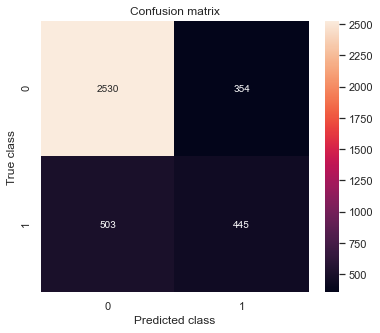

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      2884
         1.0       0.56      0.47      0.51       948

    accuracy                           0.78      3832
   macro avg       0.70      0.67      0.68      3832
weighted avg       0.77      0.78      0.77      3832



In [100]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg', random_state=1, C = 5)
lr.fit(X=X_train1, y=y_train1)
y_pred = lr.predict(X_test1)
print('Train score {}'.format(lr.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(lr.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.2 Extra Trees Classifier

Train score 0.9971585966946941
Test score 0.75


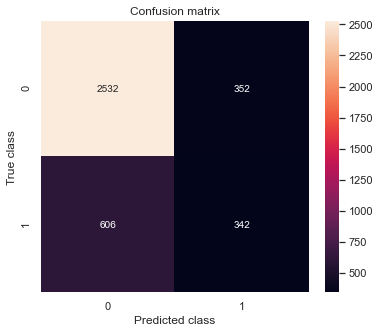

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84      2884
         1.0       0.49      0.36      0.42       948

    accuracy                           0.75      3832
   macro avg       0.65      0.62      0.63      3832
weighted avg       0.73      0.75      0.74      3832



In [101]:
from sklearn.ensemble import ExtraTreesClassifier
ExtTreesClass = ExtraTreesClassifier(n_estimators=100, random_state=123)
ExtTreesClass.fit(X=X_train1, y=y_train1)
y_pred = ExtTreesClass.predict(X_test1)
print('Train score {}'.format(ExtTreesClass.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(ExtTreesClass.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.3 Support Vector Machine Classifier

Train score 0.7454914467961729
Test score 0.7776617954070981


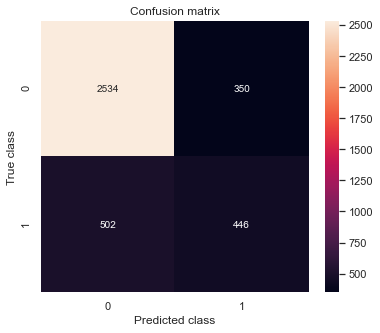

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      2884
         1.0       0.56      0.47      0.51       948

    accuracy                           0.78      3832
   macro avg       0.70      0.67      0.68      3832
weighted avg       0.77      0.78      0.77      3832



In [102]:
from sklearn import svm
svc = svm.LinearSVC()
svc.fit(X=X_train1, y=y_train1)
y_pred = svc.predict(X_test1)
print('Train score {}'.format(svc.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(svc.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.4 KNearest Neighbors Classifier

Train score 0.8148471108010696
Test score 0.7207724425887265


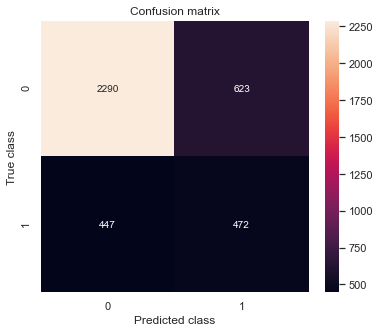

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81      2913
         1.0       0.43      0.51      0.47       919

    accuracy                           0.72      3832
   macro avg       0.63      0.65      0.64      3832
weighted avg       0.74      0.72      0.73      3832



In [111]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X=X_train1, y=y_train1)
y_pred = knn.predict(X_test1)
print('Train score {}'.format(knn.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(knn.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.5 Random Forest Classifier

Train score 0.9971585966946941
Test score 0.7609603340292276


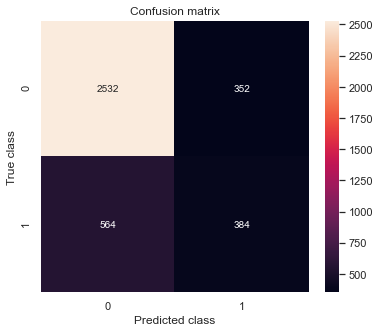

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      2884
         1.0       0.52      0.41      0.46       948

    accuracy                           0.76      3832
   macro avg       0.67      0.64      0.65      3832
weighted avg       0.74      0.76      0.75      3832



In [103]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X=X_train1, y=y_train1)
y_pred = rfc.predict(X_test1)
print('Train score {}'.format(rfc.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(rfc.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.6 XGBoost Classifier

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:02] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Train score 0.849405624818788
Test score 0.7721816283924844


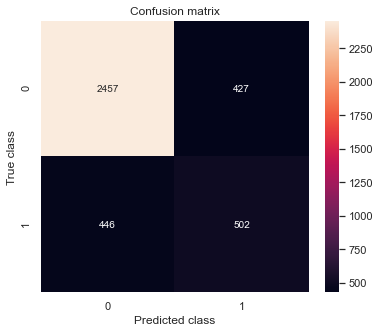

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      2884
         1.0       0.54      0.53      0.53       948

    accuracy                           0.77      3832
   macro avg       0.69      0.69      0.69      3832
weighted avg       0.77      0.77      0.77      3832



In [104]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective="binary:logistic", random_state=0)
xgb.fit(X_train1, y_train1)
y_pred = xgb.predict(X_test1)
print('Train score {}'.format(xgb.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(xgb.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.7 XGBoost RandomForest Classifier

[14:09:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score 0.7591185850971296
Test score 0.782098121085595


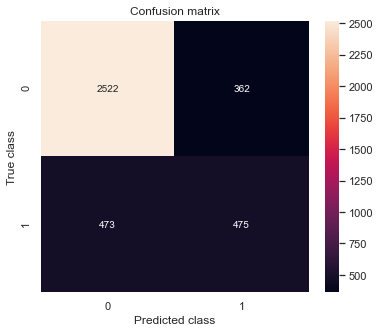

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      2884
         1.0       0.57      0.50      0.53       948

    accuracy                           0.78      3832
   macro avg       0.70      0.69      0.70      3832
weighted avg       0.77      0.78      0.78      3832



In [105]:
from xgboost import XGBRFClassifier
xgbrf = XGBRFClassifier(objective="binary:logistic", random_state=0)
xgbrf.fit(X_train1, y_train1)
y_pred = xgbrf.predict(X_test1)
print('Train score {}'.format(xgbrf.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(xgbrf.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

#### 2.2.8 Fully Connected Neural Network

D:\Programas\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train score 0.7738635042436925
Test score 0.7606993736951984


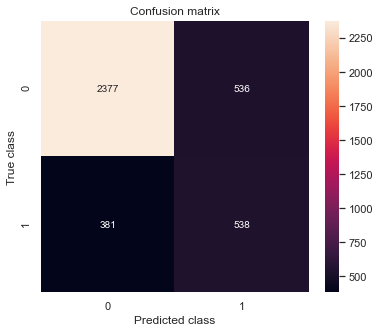

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      2913
         1.0       0.50      0.59      0.54       919

    accuracy                           0.76      3832
   macro avg       0.68      0.70      0.69      3832
weighted avg       0.78      0.76      0.77      3832



In [174]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='lbfgs', alpha=1e-3,
                    hidden_layer_sizes=(10, 2), random_state=1, verbose=2)
nn.fit(X_train1, y_train1)
y_pred = nn.predict(X_test1)
print('Train score {}'.format(nn.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(nn.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)

Todos los modelos presentan unos resultados muy similares. El score (accuracy) sobre la muestra de test está en todos los casos entre 0.75 y 0.78 (a excepción del kn neighbors). Sin embargo, sí se encuentran diferencias en el score de train, alcanzando los modelos basados en árboles de decisión (RandomForest y ExtraTrees) en 0.99, lo cual indica que haciendo un buen GridSearch se podrían encontrar soluciones que disminuyan un poco el train score y aumenten el test score, reduciendo así el overfitting. Además, el modelo XGBoost también cuenta con cierto overfitting, al ser el train score de 0.85. En el resto de modelos, el score obtenido en test es superior al obtenido en train.

### 2.3 Hyperparameter tuning

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
X_t, y_t = os.fit_resample(X, y)
X_t = full_pipeline.fit_transform(X_t)


<ipython-input-21-81bc41ebe3f9>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].apply(stringer)


In [117]:
model_names = []
model = []
best_params = []

#### 2.3.1 Logistic Regression

In [66]:
lr = LogisticRegression(random_state=1)
params = {'solver': ['newton-cg', 'lbfgs', 'saga'],
        'C': range(8),
         }
gs = GridSearchCV(estimator=lr, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model.append('Logistic Regression')
# y_proba = cross_val_predict(gs, X_train1, y_train1, cv=5, method='predict_proba')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_solver', 'param_C', 'mean_test_score']]
print(df.head(10))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


{'C': 4, 'solver': 'lbfgs'}
Train score 0.7453906353627802
Test score 0.7759220598469033
   param_solver param_C  mean_test_score
13        lbfgs       4         0.745631
14         saga       4         0.745631
6     newton-cg       2         0.745584
8          saga       2         0.745584
12    newton-cg       4         0.745584
9     newton-cg       3         0.745584
11         saga       3         0.745584
7         lbfgs       2         0.745538
16        lbfgs       5         0.745538
10        lbfgs       3         0.745538


#### 2.3.2 Extra Trees Classifier

In [71]:
etc = ExtraTreesClassifier(random_state=123)

params = {
        'max_features': ['auto', 'sqrt'],
        'max_leaf_nodes': range(8,12),
        'min_samples_leaf': range(0,10,2),
        'min_samples_split': range(4,7)
         }

gs = GridSearchCV(estimator=etc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('Extra Trees')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_max_features', 'param_max_leaf_nodes', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.9min finished


{'max_features': 'auto', 'max_leaf_nodes': 11, 'min_samples_leaf': 4, 'min_samples_split': 4}
Train score 0.6936596365565725
Test score 0.7644398051496173
    param_max_features param_max_leaf_nodes param_min_samples_leaf  \
111               sqrt                   11                      4   
112               sqrt                   11                      4   
54                auto                   11                      6   
55                auto                   11                      6   
56                auto                   11                      6   
51                auto                   11                      4   
52                auto                   11                      4   
53                auto                   11                      4   
113               sqrt                   11                      4   
114               sqrt                   11                      6   

    param_min_samples_split  mean_test_score  
111                       4

#### 2.3.3 Support Vector Machine Classifier

In [72]:
svc = svm.LinearSVC()

params = {'loss': ['hinge', 'squared_hinge'],
        'C': range(10),
         }

gs = GridSearchCV(estimator=svc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('Linear SCV')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_loss', 'param_C', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


{'C': 8, 'loss': 'squared_hinge'}
Train score 0.745788566122828
Test score 0.7780097425191371
       param_loss param_C  mean_test_score
17  squared_hinge       8         0.746419
19  squared_hinge       9         0.746094
7   squared_hinge       3         0.745816
9   squared_hinge       4         0.745770
5   squared_hinge       2         0.745770
3   squared_hinge       1         0.745770
11  squared_hinge       5         0.745723
13  squared_hinge       6         0.745677
15  squared_hinge       7         0.745445
10          hinge       5         0.743869


D:\Programas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### 2.3.4 Random Forest

In [75]:
rfc = RandomForestClassifier(random_state=123, n_jobs=-1)

params = {'max_depth': range(8,20,2),
        'max_features': ['auto', 'sqrt'],
        'max_leaf_nodes': range(8,12),
        'min_samples_leaf': range(16,22,2),
        'min_samples_split': range(4,7)
         }

gs = GridSearchCV(estimator=rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('Random Forest')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 22.6min finished


{'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': 11, 'min_samples_leaf': 20, 'min_samples_split': 4}
Train score 0.7323252420745457
Test score 0.779053583855254
    param_max_depth param_max_features param_max_leaf_nodes  \
69                8               sqrt                   11   
71                8               sqrt                   11   
70                8               sqrt                   11   
33                8               auto                   11   
34                8               auto                   11   
35                8               auto                   11   
429              18               sqrt                   11   
287              14               sqrt                   11   
286              14               sqrt                   11   
285              14               sqrt                   11   

    param_min_samples_leaf param_min_samples_split  mean_test_score  
69                      20                       4         0.7337

#### 2.3.5 XGBoost

In [76]:
xgb = XGBClassifier(objective="binary:logistic", random_state=0)

params = {
        'max_depth': [6,7,8,9,10],
        'booster': ['gbtree', 'dart'],
        'reg_alpha': [0, 0.0001, 0.001]
         }

gs = GridSearchCV(estimator=xgb, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('XGBoost')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_max_depth', 'param_booster', 'param_reg_alpha', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
D:\Programas\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 26.9min finished
D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'max_depth': 10, 'reg_alpha': 0.0001}
Train score 0.930959013131715
Test score 0.9321503131524008
   param_max_depth param_booster param_reg_alpha  mean_test_score
13              10        gbtree          0.0001         0.802606
28              10          dart          0.0001         0.802606
14              10        gbtree           0.001         0.800845
29              10          dart           0.001         0.800845
12              10        gbtree               0         0.800427
27              10          dart               0         0.800427
11               9        gbtree           0.001         0.797599
26               9          dart           0.001         0.797599
9                9        gbtree  

D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [79]:
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))

Train score 0.930959013131715
Test score 0.9321503131524008


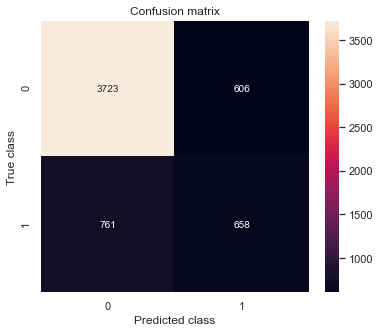

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      4329
         1.0       0.52      0.46      0.49      1419

    accuracy                           0.76      5748
   macro avg       0.68      0.66      0.67      5748
weighted avg       0.75      0.76      0.76      5748



In [92]:
y_pred = gs.predict(X_test1)
mostrar_resultados(y_test, y_pred)

In [89]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(gs.best_estimator_, X_t, y_t, cv=5)))

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:09] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Aunque tras obtener el score del mejor modelo sobre el conjunto de test se obtiene un 0.93, haciendo uso de la función mostrar_resultados se observa que el accuracy realmente está en torno a 0.76. Si probamos de nuevo a entrenar un modelo con los parámetros obtenidos, efectivamente se obtiene un score de 0.76

In [107]:
clfqq = XGBClassifier(**gs.best_params_, n_jobs=-1)
clfqq.fit(X_train1, y_train1)
print(clfqq.score(X=X_train1, y=y_train1))
print(clfqq.score(X=X_test1, y=y_test))

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9525079733256017
0.7536534446764092


D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


#### 2.3.6 XGBoost Random Forest

In [95]:
xgbrf = XGBRFClassifier(objective="binary:logistic", random_state=0)

params = {'n_estimators': [60,80,100,120],
        'max_depth': [6,7,8,9,10],
        'booster': ['gbtree', 'dart'],
        'reg_alpha': [0, 0.0001, 0.001]
         }

gs = GridSearchCV(estimator=xgbrf, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('XGBoost Random Forest')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_n_estimators', 'param_max_depth', 'param_booster', 'param_reg_alpha', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 33.4min finished
D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0}
Train score 0.7929433611884865
Test score 0.8056715379262352
    param_n_estimators param_max_depth param_booster param_reg_alpha  \
54                 100              10        gbtree               0   
114                100              10          dart               0   
119                120              10          dart           0.001   
59                 120              10        gbtree           0.001   
117                120              10          dart               0   
58                 120              10        gbtree          0.0001   
57                 120              10        gbtree               0   
118                120             

D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [110]:
clf1 = XGBRFClassifier(**gs.best_params_, n_jobs=-1)
clf1.fit(X_train1, y_train1)
print(clf1.score(X=X_train1, y=y_train1))
print(clf1.score(X=X_test1, y=y_test))

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:12:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.800313916986397
0.7758350730688935


D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


#### 2.3.7 Multi-layer Percceptron (Fully Connected Neural Network)

In [113]:
nn = MLPClassifier(random_state=0)

params = {'activation': ['logistic', 'relu'],
        'hidden_layer_sizes': [(10,5,2), (20,2), (12,2), (10,2)],
        'solver': ['lbfgs', 'adam'],
        'alpha': [0, 0.0001, 0.001]
         }

gs = GridSearchCV(estimator=nn, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('Multi-layer Perceptron')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_activation', 'param_hidden_layer_sizes', 'param_solver', 'param_alpha', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 16.8min finished


{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 5, 2), 'solver': 'adam'}
Train score 0.7664225090105802
Test score 0.7870563674321504
   param_activation param_hidden_layer_sizes param_solver param_alpha  \
9          logistic               (10, 5, 2)         adam      0.0001   
38             relu                  (10, 2)        lbfgs      0.0001   
1          logistic               (10, 5, 2)         adam           0   
17         logistic               (10, 5, 2)         adam       0.001   
46             relu                  (10, 2)        lbfgs       0.001   
7          logistic                  (10, 2)         adam           0   
30             relu                  (10, 2)        lbfgs           0   
15         logistic                  (10, 2)         adam      0.0001   
13         logistic                  (12, 2)         adam      0.0001   
5          logistic                  (12, 2)         adam           0   

    mean_test_score  
9          0.7586

D:\Programas\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [338]:
model_names = ['Logistic Regression', 'Extra Trees', 'Random Forest', 'XGBoost', 'XGBoost Random Forest', 'Multi-layer Perceptron']

In [339]:
best_params = [{'C': 4, 'solver': 'lbfgs'}, {'max_features': 'auto', 'max_leaf_nodes': 11, 'min_samples_leaf': 4, 'min_samples_split': 4}, 
              {'C': 8, 'loss': 'squared_hinge'}, {'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': 11, 'min_samples_leaf': 20, 'min_samples_split': 4},
              {'booster': 'gbtree', 'max_depth': 10, 'reg_alpha': 0.0001},{'booster': 'gbtree', 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0},
              {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 5, 2), 'solver': 'adam'}]

In [340]:
model = [LogisticRegression(**best_params[0]), ExtraTreesClassifier(**best_params[1]), 
      RandomForestClassifier(**best_params[3]), XGBClassifier(**best_params[4]), XGBRFClassifier(**best_params[5]),
      MLPClassifier(**best_params[6])]

In [164]:
predictions = []
from sklearn.model_selection import cross_val_predict
for i in model:
    predictions.append(cross_val_predict(i, X_t, y_t, cv=5, method='predict_proba'))
    

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:49] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:17] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

D:\Programas\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Programas\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Programas\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 2.4 Model comparison

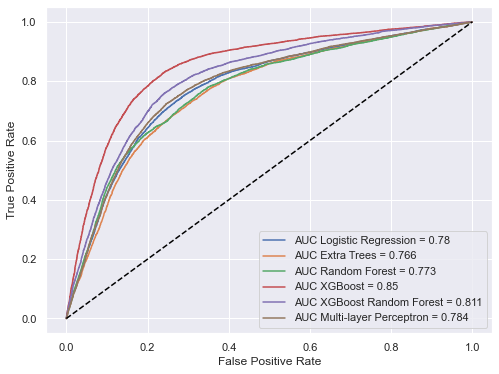

In [171]:
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(8,6))
for i in range(len(model)):
    fpr, tpr, thre = roc_curve(y_t, predictions[i][:,1])
    roc_auc = roc_auc_score(y_t, predictions[i][:,1])

    plt.plot(fpr, tpr, label='AUC {} = {a}'.format(model_names[i], a=round(roc_auc, 3)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
plt.plot([0, 1], '--', c='black')
plt.show()

In [160]:
predictions1 = []
for i in model:
    i.fit(X_train1, y_train1)
    predictions1.append(i.predict_proba(X_test1))

D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:21] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[23:11:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


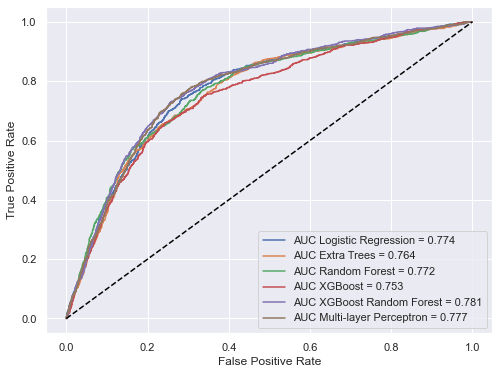

In [172]:
idx=1
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(8,6))
for i in range(len(model)):
    fpr, tpr, thre = roc_curve(y_test, predictions1[i][:,1])
    roc_auc = roc_auc_score(y_test, predictions1[i][:,1])

    plt.plot(fpr, tpr, label='AUC {} = {a}'.format(model_names[i], a=round(roc_auc, 3)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
plt.plot([0, 1], '--', c='black')
plt.show()

In [341]:

from sklearn.metrics import accuracy_score
predictions2 = []
for i in model:
    i.fit(X_train1, y_train1)
    predictions2.append(i.predict(X_test1))

metrics = np.zeros((len(model), 3))
for i in range(len(model)):
    metrics[i, 0] = f1_score(y_test, predictions2[i])
    metrics[i, 1] = accuracy_score(y_test, predictions2[i])
    metrics[i, 2] = precision_score(y_test, predictions2[i])
    
metrics = pd.DataFrame(metrics, columns=['F1 Score', 'Accuracy', 'Precision'], index=model_names)

D:\Programas\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:00:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Programas\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [342]:
print(metrics)

                        F1 Score  Accuracy  Precision
Logistic Regression     0.453317  0.767745   0.520451
Extra Trees             0.203209  0.766701   0.561576
Random Forest           0.370532  0.774791   0.561947
XGBoost                 0.481886  0.764875   0.510976
XGBoost Random Forest   0.546316  0.775052   0.529052
Multi-layer Perceptron  0.516060  0.764092   0.507903


## CONCLUSIONES

Tras realizar el grid search sobre varios de los modelos (todos los vistos en el apartado anterior menos el KNN, ya que proporcionaba un score bastante menor que el resto), observamos que los modelos que mejor score promedio obtienen en test tras el cross validation son el XGBoost y el XGRFBoost, llegando el XGBoost a obtener un accuracy medio de 0.8026. Sin embargo, si luego evaluamos el modelo obtenido sobre un conjunto de train y test separados, los resultados terminan siendo inferiores (disminuye a 0.7536). En el caso del XGRFBoost, ocurre lo contrario, y aumenta de 0.7673 en CV a 0.7758 en test una vez realizado el entrenamiento sobre elmejor estimador.

Tras pintar las curvas ROC para todos los modelos (menos para el LinearSVC que no admite el método predict_proba), observamos que, haciendo un cross val predict, efectivamente los modelos con una AUC más alta son el XGBoost y el XGRFBoost, seguidos de la red neuronal MLP. Sin embargo, si volvemos a entrenar los modelos con los datos de train y test, se observan cosas algo diferentes.Ahora el modelo con mayor AUC es el XGRFBoost, seguido de la red neuronal, pero el modelo XGBoost es el que menor AUC muestra.

Si nos centramos en la perspectiva de negocio, podemos determinar que la posición menos favorable para una empresa sería predecir que un empleado no se va a ir, cuando realmente este sí tiene intención de cambiar de trabajo. Es decir, los False Negatives son los valores más perjudiciales y por tanto debemos tratar de reducirlos. Si nos fijamos en las matrices de confusión del análisis inicial de los modelos, el modelo que más reduce esta ratio es la red neuronal, siendo la única con menos de 400 FN. Los siguientes mejores son el XGBoost, el modelo KNN (el cual descartamos por otras razones) y el XGRFBoost.

Todos los indicios indican que los modelos que mejor se deberían comportar este problema en cuestión son:
- XGBoost
- XGRFBoost 
- MLP

Es por eso que vamos a continuar explorando posibilidades con estos tres modelos, y vamos a comprobar si las variables encontradas en el proceso de feature engineering surten efecto.


## 3. Análisis final (mejores modelos + feature engineering)

Ahora que ya hemos seleccionado los mejores modelos, vamos a realizar ciertas transformaciones nuevas sobre el pipeline de datos, probando a crear nuevas variables y a eliminar otras que consideremos poco relevante, en función de las conclusiones obtenidas en el notebook *Feature_Engineering*.

In [332]:
# pasos del pipeline categórico
cat_steps = [
    ('selector', DataFrameSelector(cat_cols)),
    # Creamos las features que necesitemos
    ('creator1', CreateFeatures(combine_features, col1='experiencia', col2='experiencia_relevante',
                               new_col_name='exp_exp-rel', f1=buckets_experiencia)),
#     ('creator5', CreateFeatures(buckets_experiencia, col1='experiencia')),
#     ('creator2', CreateFeatures(combine_features, col1='experiencia', col2='tamano_compania',
#                                new_col_name='exp_tam', f1=buckets_experiencia, f2=buckets_tam_compania)),
#     ('creator3', CreateFeatures(combine_features, col1='ultimo_nuevo_trabajo', col2='tamano_compania',
#                                new_col_name='ult_tam', f2=buckets_tam_compania)),
#     ('creator4', CreateFeatures(combine_features, col1='exp_exp-rel', col2='universidad_matriculado',
#                                new_col_name='exp_exp-rel_uni')),
#     ('creator6', CreateFeatures(combine_features, col1='experiencia', col2='universidad_matriculado',
#                                new_col_name='exp_uni')),
    ('dropper', DropFeatures(['tipo_compania', 'ciudad', 'educacion'])),
    ('stringer', Stringer()),
    ('imputer', Imputer(strategy='most_frequent')),
    ('encoder', Encoder(limit=20))
]

# Pasos del pipeline numérico
num_steps = [
    ('selector', DataFrameSelector(num_cols)),
    ('dropper', DropFeatures(['empleado_id'])),
    ('imputer', Imputer(strategy='median')),
    ('scaler', MinMaxScaler())
]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

# Concatenación de pipelines
full_pipeline = FeatureUnion([
    ('numeric_pipeline', num_pipeline),
    ('categorical_pipeline', cat_pipeline)
])

In [333]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Separamos la variable objetivo
y = data['target']
X = data.drop('target', axis=1)
# Generamos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Aplicamos el oversampling
os =  RandomOverSampler(random_state=1, sampling_strategy=0.5)
X_train_res, y_train1 = os.fit_resample(X_train, y_train)

# Aplicamos el pipeline de transformación
X_train1 = full_pipeline.fit_transform(X_train_res)
X_test1 = full_pipeline.transform(X_test)

X_t, y_t = os.fit_resample(X, y)
X_t = full_pipeline.fit_transform(X_t)

In [316]:
final_models = model[-3:]
final_model_names = model_names[-3:]

XGBOOST
[01:51:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Train score XGBoost 0.945645855133124
Test score XGBoost 0.764874739039666


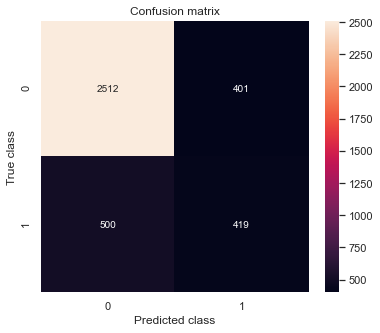

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85      2913
         1.0       0.51      0.46      0.48       919

    accuracy                           0.76      3832
   macro avg       0.67      0.66      0.66      3832
weighted avg       0.76      0.76      0.76      3832

XGBOOST RANDOM FOREST
[01:52:09] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score XGBoost Random Forest 0.7978723404255319
Test score XGBoost Random Forest 0.7750521920668059


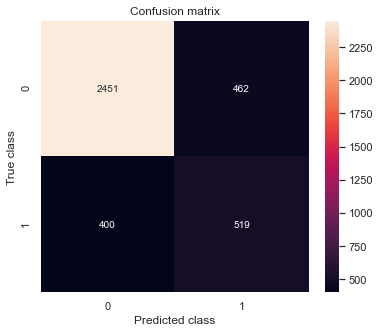

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      2913
         1.0       0.53      0.56      0.55       919

    accuracy                           0.78      3832
   macro avg       0.69      0.70      0.70      3832
weighted avg       0.78      0.78      0.78      3832

MULTI-LAYER PERCEPTRON
Train score Multi-layer Perceptron 0.7368910591791652
Test score Multi-layer Perceptron 0.7552192066805845


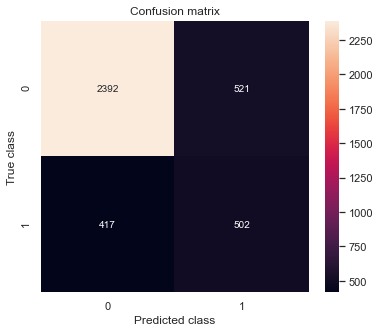

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      2913
         1.0       0.49      0.55      0.52       919

    accuracy                           0.76      3832
   macro avg       0.67      0.68      0.68      3832
weighted avg       0.77      0.76      0.76      3832



In [317]:
for i, m in enumerate(final_models):
    print(final_model_names[i].upper())
    m.fit(X_train1, y_train1)
    y_pred = m.predict(X_test1)
    print('Train score {} {}'.format(final_model_names[i], m.score(X=X_train1, y=y_train1)))
    print('Test score {} {}'.format(final_model_names[i], m.score(X=X_test1, y=y_test)))
    mostrar_resultados(y_test, y_pred)


Tras realizar varias comprobaciones, parece que el modelo que mejor accuracy consigue en el set de test es el **XGRFBoost**, logrando un score cercano al 0.78. Esto se logra añadiendo la variable combinada entre experiencia y experiencia relevante, y eliminando además la variable *tipo_compania*. Aunque a priori parecía que las variables *ciudad* y *educacion* sería las menos relevantes para el modelo, según el notebook de feature engineering, su eliminación no contribuye a mejorar la precisión del modelo, sino que además la disminuye.

Aunque la eliminación de dichas dos variables no influya en el accuracy, si que contribuye a disminuir el número de False Negatives, por lo que su inclusión podría estar justificada.

Por lo general, los resultados obtenidos son muy pobres. El accuracy es poco superior al 0.75, y eso teniendo en cuenta que el dataset contiene un 75% de valores correspondientes a la clase *0*. Por lo tanto, es importante observar que en el modelo escogido, los valores de F1 score indican que se mejora el 75% de acierto para la clase *0* (F1 score = 0.85) y el 50% de acierto para la clase *1* (F1 score = 0.55). Es decir, el modelo es capaz de predecir la fuga mejor que si lo escogiéramos de manera aleatoria.

Por último, dado que ya conocemos el mejora candidato, vamos a proceder a realizar un nuevo grid search sobre este modelo teniendo en cuenta el nuevo pipeline

### 3.1 Modelo final

In [319]:
xgbrf = XGBRFClassifier(objective="binary:logistic", random_state=0)

params = {'n_estimators': [60,80,100,120],
        'max_depth': range(8,12),
        'booster': ['gbtree', 'dart'],
        'reg_alpha': [0, 0.0001, 0.001]
         }

gs = GridSearchCV(estimator=xgbrf, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_t, y_t)
print(gs.best_params_)
model_names.append('XGBoost Random Forest')
model.append(gs)
best_params.append(gs.best_params_)
print('Train score {}'.format(gs.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(gs.score(X=X_test1, y=y_test)))
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
df = results[['param_n_estimators', 'param_max_depth', 'param_booster', 'param_reg_alpha', 'mean_test_score']]
print(df.head(10))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 33.9min finished
D:\Programas\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'max_depth': 11, 'n_estimators': 60, 'reg_alpha': 0.001}
Train score 0.801999767468899
Test score 0.8105427974947808
   param_n_estimators param_max_depth param_booster param_reg_alpha  \
86                 60              11          dart           0.001   
38                 60              11        gbtree           0.001   
37                 60              11        gbtree          0.0001   
84                 60              11          dart               0   
85                 60              11          dart          0.0001   
36                 60              11        gbtree               0   
47                120              11        gbtree           0.001   
95                120              11    

D:\Programas\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[09:10:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score 0.8106034182071852
Test score 0.776356993736952


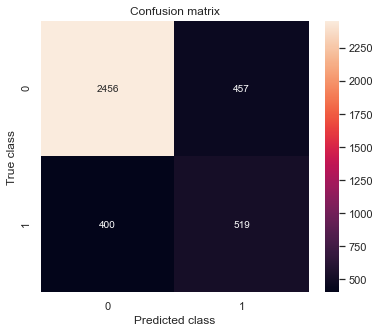

F1 score = 0.5477572559366755
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      2913
         1.0       0.53      0.56      0.55       919

    accuracy                           0.78      3832
   macro avg       0.70      0.70      0.70      3832
weighted avg       0.78      0.78      0.78      3832



In [327]:
xgbrf = XGBRFClassifier(**gs.best_params_)
xgbrf.fit(X_train1, y_train1)
y_pred = xgbrf.predict(X_test1)
print('Train score {}'.format(xgbrf.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(xgbrf.score(X=X_test1, y=y_test)))
mostrar_resultados(y_test, y_pred)